In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import fnmatch
import scipy.io as sio

from subprocess import check_output
from glob import glob
from PIL import Image
from pathlib import Path

import matplotlib.pylab as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [4]:
'''num_cores = 4
CPU = False

if not CPU:
    num_GPU = 2
    num_CPU = 0
else:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)'''

"num_cores = 4\nCPU = False\n\nif not CPU:\n    num_GPU = 2\n    num_CPU = 0\nelse:\n    num_CPU = 1\n    num_GPU = 0\n\nconfig = tf.ConfigProto(intra_op_parallelism_threads=num_cores,        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})\nsession = tf.Session(config=config)\nK.set_session(session)"

## Load Data

In [5]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

source_path = "I:\\Honours-Project\\data\\sorted\\agg\\cropped\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [6]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

In [7]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(df.groupby('flow_rate').size())

flow_rate
1800    116
3600    116
7200    116
dtype: int64


In [8]:
df.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks
245,75_flipped,2017.11.17,7200,8.05 s.tifheightmap.mat,12.802491,12293,91375.269340,0.987315,1,0.380141,7.433114,[[1.22930000e+04 2.31417800e+06 6.05907654e+08...,-1.526457,836.587878,[[ 376.38318157 -598.98373804]\r\n [ -598.98...,0,2
99,29,2017.11.17,1800,21.41 s.tifheightmap.mat,9.239291,1662,8269.811594,0.594737,1,0.786932,4.975819,[[1.66200000e+03 4.06070000e+04 1.25490700e+06...,1.141600,167.053824,[[119.16568124 22.54220192]\r\n [ 22.54220192...,0,1
31,132_flipped,2017.11.23,1800,26.20 s.tifheightmap.mat,9.358412,5355,24621.497101,0.668227,0,0.767742,4.597852,[[5.35500000e+03 2.30840000e+05 1.30236900e+07...,-1.151411,335.622366,[[ 388.86804988 -102.91215484]\r\n [-102.91215...,0,1
261,197_flipped,2017.11.23,7200,36.00 s.tifheightmap.mat,19.083013,3122,29222.399419,0.957761,1,0.315992,9.360154,[[3.12200000e+03 1.79358000e+05 1.46038540e+07...,1.295739,306.835570,[[ 222.11597891 354.20156308]\r\n [ 354.20156...,0,2
298,72,2017.11.17,7200,5.20 s.tifheightmap.mat,6.577711,7998,12404.227215,0.999753,1,0.537934,1.549560,[[8.00500000e+03 2.60840000e+06 1.17772984e+09...,-1.569433,1380.818326,[[ 2.02879511e+01 -5.57794988e+01]\r\n [-5.577...,1,1


In [9]:
x = []
y = []

for path in df['name']:
    x.append(np.load(source_path+path+".npy"))
    
x = np.array(x)
y = df["flow_rate"].values

In [10]:
x_test_df = pd.concat([df[df['flow_rate']==i].sample(n=10) for i in (1800,3600,7200)],ignore_index=True)
y_test = x_test_df['flow_rate'].values

x_train_df = pd.concat([df, x_test_df, x_test_df]).drop_duplicates(keep=False)
y_train = x_train_df['flow_rate'].values

x_test = []
x_train = [] 

for path in x_test_df['name']:
    x_test.append(np.load(source_path+path+".npy"))
    
x_test = np.array(x_test)

for path in x_train_df['name']:
    x_train.append(np.load(source_path+path+".npy"))
    
x_train = np.array(x_train)

In [11]:
std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [12]:
nb_classes = 3

y_train[y_train == 1800] = 0
y_train[y_train == 3600] = 1
y_train[y_train == 7200] = 2

y_test[y_test == 1800] = 0
y_test[y_test == 3600] = 1
y_test[y_test == 7200] = 2

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [16]:
print(x_test.shape)
x_test = x_test.reshape(30,647,277,1)

print(x_train.shape)
x_train = x_train.reshape(318,647,277,1)

(30, 647, 277, 1)
(318, 647, 277, 1)


## Run CNN

In [17]:
# Set the CNN model 
def build_cnn_model(input_dim, output_dim):
    model = Sequential()

    model.add(Conv2D(filters = 8, kernel_size = (7,7), 
                     activation ='relu', input_shape=input_dim))
    model.add(MaxPool2D(pool_size=(2,2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(filters = 16, kernel_size = (5,5), 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    # model.add(Dropout(0.25))

    model.add(Flatten())
    # model.add(Dense(16, activation = "relu"))
    # model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation = "softmax"))
    
    return model

In [18]:
print(x_train.shape[1:])

(647, 277, 1)


In [19]:
model = build_cnn_model(x_train.shape[1:], nb_classes)

In [20]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 641, 271, 8)       400       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 320, 135, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 316, 131, 16)      3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 158, 65, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 156, 63, 32)       4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 78, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 76, 29, 64)        18496     
__________

In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
epochs = 10 
batch_size = 1

In [25]:
# Fit the model
"""history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])"""
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[learning_rate_reduction])
score = model.evaluate(x_test, y_test, verbose=0)

Train on 318 samples, validate on 30 samples
Epoch 1/10
 - 7s - loss: 1.1038 - acc: 0.3208 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 2/10
 - 6s - loss: 1.0994 - acc: 0.3050 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/10
 - 6s - loss: 1.0994 - acc: 0.3082 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/10
 - 6s - loss: 1.0993 - acc: 0.3113 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/10
 - 6s - loss: 1.0993 - acc: 0.3082 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
 - 6s - loss: 1.0990 - acc: 0.2862 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/10
 - 6s - loss: 1.0990 - acc: 0.3270 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/10
 - 6s - loss: 1.0990 - acc: 0.2925 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/10
 - 6s - loss: 1.0988 - acc: 0.3302 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 10/10
 - 6s - loss: 1.0988 - acc: 0.3208

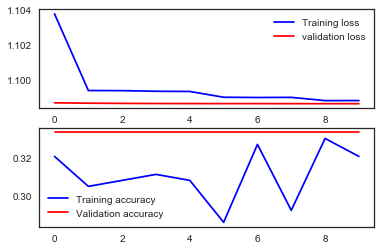

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

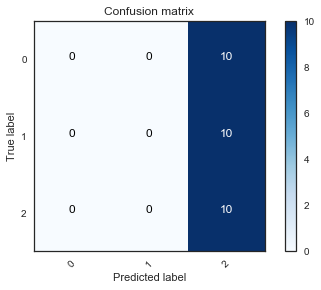

In [29]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(Y_true), np.array(Y_pred_classes)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## With Cross Validation:

In [30]:
input_dim = x_train.shape[1:]

In [31]:
model = None
model = build_cnn_model(input_dim, nb_classes)

In [32]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

    # Fit the model
    """history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])"""
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2, 
                        validation_data=(x_test, y_test), 
                        callbacks=[learning_rate_reduction])
    score = model.evaluate(x_test, y_test, verbose=0)
    
    return score[1]

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 641, 271, 8)       400       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 320, 135, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 316, 131, 16)      3216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 158, 65, 16)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 156, 63, 32)       4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 78, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 76, 29, 64)        18496     
__________

In [34]:
print(x_train.shape)

(318, 647, 277, 1)


In [35]:
n_folds = 10

labels = df['flow_rate'].values
data = x

labels[labels == 1800] = 0
labels[labels == 3600] = 1
labels[labels == 7200] = 2

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

i = 0

for train, test in skf.split(x,y):
    print("Running Fold", i+1, "/", n_folds)
    i+=1
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
            
    x_train = (data[train] - mean)/std
    x_train = np.reshape(x_train, (len(train), 647, 277, 1))
    x_test = (data[test] - mean)/std 
    x_test = np.reshape(x_test, (len(test), 647, 277, 1))
    
    input_dim = x_train.shape[1:]
    
    model = None # Clearing the NN.
    model = build_cnn_model(input_dim, nb_classes)
        
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Train on 312 samples, validate on 36 samples
Epoch 1/10
 - 6s - loss: 1.0989 - acc: 0.2724 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/10
 - 6s - loss: 1.0988 - acc: 0.2949 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/10
 - 6s - loss: 1.0988 - acc: 0.3141 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/10
 - 6s - loss: 1.0988 - acc: 0.2788 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/10
 - 6s - loss: 1.0988 - acc: 0.3173 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 6/10
 - 6s - loss: 1.0987 - acc: 0.3141 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/10
 - 7s - loss: 1.0987 - acc: 0.3173 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/10
 - 7s - loss: 1.0987 - acc: 0.3141 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00008: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 9/10
 - 6s - loss: 1.0987 - acc: 0.3045 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 10/10
 - 6s - loss: 1.0987 - acc: 0.3269 

 - 6s - loss: 1.0986 - acc: 0.2921 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 9/10
 - 6s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 10/10
 - 6s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Running Fold 10 / 10
Train on 315 samples, validate on 33 samples
Epoch 1/10
 - 6s - loss: 1.0986 - acc: 0.2952 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/10
 - 6s - loss: 1.0986 - acc: 0.2762 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/10
 - 6s - loss: 1.0986 - acc: 0.3143 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/10
 - 6s - loss: 1.0986 - acc: 0.2952 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/10
 - 6s - loss: 1.0986 - acc: 0.3270 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/10
 - 6s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/10
 - 6s - loss: 1.0986 - acc: 0.2825 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/10
 - 6s - loss: 1.0986 - acc: 0.2952 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 9/10
 - 6s - loss: 1.0986

In [36]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.33333333333333337


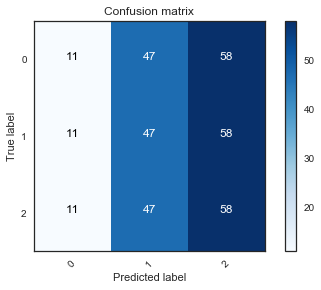

In [37]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 